In [1]:
import numpy as np
import random

import os
import pickle
import sys
import timeit

import pandas as pd
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr 

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.pyplot import imshow
%matplotlib inline 

from IPython.display import Image 

from util import fit_IPTW_LR, fit_IPTW_RF, fit_IPTW_SVM
from util import sim_Data, sim_Unobs_Data, evaluation, placebo_confounder, bayes_unobs_confounder, refutation_analysis
import pickle

<img src="split_treatment.png" width="400"/>

## Generate data with no-unobs. confounding

Avg compliance: 0.9000000000000001
Fit IPTW + LR
p_A: 0.55, IPTW: 1.00 +/- 0.05
Est. Y_0 RMSE: 0.010015300908924728
Est. Y_1 RMSE: 0.04437775706051184
95.3% A matched Z, RMSE: 0.14
Fit IPTW + SVM
p_A: 0.55, IPTW: 1.00 +/- 0.05
Est. Y_0 RMSE: 0.013230700652678866
Est. Y_1 RMSE: 0.24543049002673697
95.3% A matched Z, RMSE: 0.19


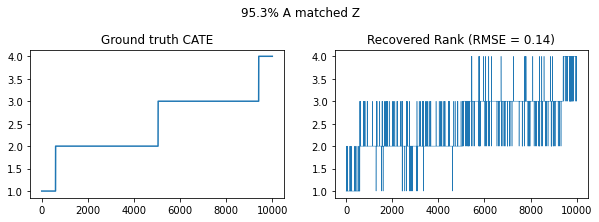

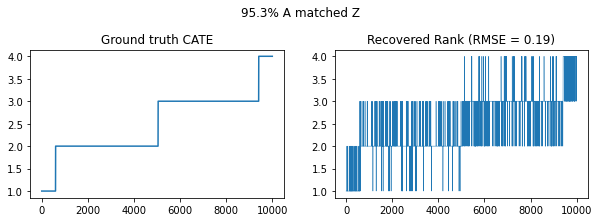

In [2]:
xDim = 50
nSim = 10000

p_AgivenZ = 1
p_AgivenNotZ = 0.1
        
X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)

print('Fit IPTW + LR')
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

print('Fit IPTW + SVM')
Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data, A_data, nObs)
a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 1: Generate data with unobs. confounding

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 1
p_AgivenNotZ = 0.1

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Unobs_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data,A_data, nObs)
a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 2: Generate data violating the split-treatment criterion 

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.6
p_AgivenNotZ = 0.7

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

# Refutation Analysis

## Placebo Confounder

In [ ]:
methods=['IPTW_LR', 'IPTW_SVM']

for method in methods:
    xDim = 50
    nSim = 10000

    #Data Generation
    # A percentage Z match 77% params
    p_AgivenZ= 0.8
    p_AgivenNotZ=0.2

    X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
    print(np.sum(Y_0_data), np.sum(Y_1_data))

    # No Confounder
    if method == 'IPTW_LR':
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
    elif method == 'IPTW_SVM':
        Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data, A_data, nObs)

    a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
    print('% of A matched Z', a_matched_z)
    print('Mean recovered rank without Placebo Treatment: ', rmse, np.mean(recovered_rank))


    #Placebo Confounder
    A_matched_Z_unobs = []
    RMSEs_unobs = []

    A_data_placebo= placebo_confounder(X_data, A_data, Y_data)

    #Results on Confounded Data
    if method == 'IPTW_LR':
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data,  A_data_placebo, nObs)
    elif method == 'IPTW_SVM':
        Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data,  A_data_placebo, nObs)

    a_matched_z, rmse, recovered_rank = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A_data_placebo, Z)
    print('% of A matched Z', a_matched_z)
    print('Mean recovered rank with Placebo Treatment: ', rmse, np.mean(recovered_rank))

## Unobserved Confounder Test

Avg compliance: 0.5999999999999999
-83.36385677243334 833449.9694765608
p_A: 0.4991, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.004507200308022059
Est. Y_1 RMSE: 0.04824671777309086
80.7% A matched Z, RMSE: 0.14
% of A matched Z 0.8068
Alpha:  1000  Sample_size :  5009  Sum_  -0.14649342264452941 -733.7855540264478 0.05313661596278487
Alpha:  1000  Sample_size :  4991  Sum_  83.5805292921767 417150.42169725394 83.76430723102042


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4991, IPTW: 1.00 +/- 0.90
Est. Y_0 RMSE: 0.015224461179703235
Est. Y_1 RMSE: 0.3329762118268114
80.7% A matched Z, RMSE: 0.15
Final
Correlation Treatment:  0.5140871808530425
Correlation Outcome:  0.4790445715657531
[2. 3. 3. ... 4. 4. 4.]
Alpha:  5000  Sample_size :  5009  Sum_  -0.14649342264452941 -733.7855540264478 0.8515398095755593
Alpha:  5000  Sample_size :  4991  Sum_  83.5805292921767 417150.42169725394 84.56558928230247


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4991, IPTW: 1.00 +/- 0.97
Est. Y_0 RMSE: 0.0058226844330174
Est. Y_1 RMSE: 0.04859855810163027
80.7% A matched Z, RMSE: 0.15
Final
Correlation Treatment:  0.5058244836310639
Correlation Outcome:  0.45629445083884307
[2. 3. 3. ... 4. 3. 4.]
Alpha:  10000  Sample_size :  5009  Sum_  -0.14649342264452941 -733.7855540264478 1.8495438015915273
Alpha:  10000  Sample_size :  4991  Sum_  83.5805292921767 417150.42169725394 85.56719184640504


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4991, IPTW: 1.00 +/- 0.52
Est. Y_0 RMSE: 0.0019814116394738634
Est. Y_1 RMSE: 0.01990225369972627
80.7% A matched Z, RMSE: 0.14
Final
Correlation Treatment:  0.38688874558554676
Correlation Outcome:  0.35139587729832955
[2. 3. 3. ... 4. 3. 4.]
Alpha:  50000  Sample_size :  5009  Sum_  -0.14649342264452941 -733.7855540264478 9.833575737719272
Alpha:  50000  Sample_size :  4991  Sum_  83.5805292921767 417150.42169725394 93.58001235922555


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4991, IPTW: 1.00 +/- 0.21
Est. Y_0 RMSE: 0.006937952176074642
Est. Y_1 RMSE: 0.04700018748151663
80.7% A matched Z, RMSE: 0.14
Final
Correlation Treatment:  0.1855566464838302
Correlation Outcome:  0.17679535251549752
[2. 3. 3. ... 4. 3. 4.]
Alpha:  100000  Sample_size :  5009  Sum_  -0.14649342264452941 -733.7855540264478 19.813615657878955
Alpha:  100000  Sample_size :  4991  Sum_  83.5805292921767 417150.42169725394 103.59603800025118
p_A: 0.4991, IPTW: 1.00 +/- 0.15
Est. Y_0 RMSE: 0.005793591113585985
Est. Y_1 RMSE: 0.06102837549886089
80.7% A matched Z, RMSE: 0.14
Final
Correlation Treatment:  0.12371865035784241
Correlation Outcome:  0.11147806822477467
[2. 3. 3. ... 4. 4. 4.]
[4 3 2 1 0] [0.15297059 0.14899664 0.13928388 0.14       0.1356466 ]
Avg compliance: 0.5999999999999999
3407.2409710516645 842873.9076377183
p_A: 0.5007, IPTW: 1.00 +/- 0.06
Est. Y_0 RMSE: 0.03848685953588683
Est. Y_1 RMSE: 0.3033529507556977
79.5% A matched Z, RMSE: 0.21
% of A matched Z 0.795
Alpha

/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 0.019316091843232186
Est. Y_1 RMSE: 0.2511001850768002
79.5% A matched Z, RMSE: 0.24
Final
Correlation Treatment:  0.5333043165121969
Correlation Outcome:  0.4038809562213465
[2. 3. 3. ... 2. 4. 3.]
Alpha:  5000  Sample_size :  4993  Sum_  0.10800545482604842 539.2712359464598 1.1091852695127071
Alpha:  5000  Sample_size :  5007  Sum_  85.3740702486729 427467.9697351052 86.35562494710567


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.5007, IPTW: 1.00 +/- 0.88


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 0.6179647508833581
Est. Y_1 RMSE: 0.7451895312129669
79.5% A matched Z, RMSE: 0.25
Final
Correlation Treatment:  0.5157169051618391
Correlation Outcome:  0.3916588656125946
[2. 3. 3. ... 2. 4. 3.]
Alpha:  10000  Sample_size :  4993  Sum_  0.10800545482604842 539.2712359464598 2.1103867112427834
Alpha:  10000  Sample_size :  5007  Sum_  85.3740702486729 427467.9697351052 87.35402750301621


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.5007, IPTW: 1.00 +/- 0.49


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 0.05076893123709217
Est. Y_1 RMSE: 0.3728656416957501
79.5% A matched Z, RMSE: 0.23
Final
Correlation Treatment:  0.38019787900520874
Correlation Outcome:  0.2907101889189792
[2. 3. 3. ... 2. 4. 3.]
Alpha:  50000  Sample_size :  4993  Sum_  0.10800545482604842 539.2712359464598 10.11999824508339
Alpha:  50000  Sample_size :  5007  Sum_  85.3740702486729 427467.9697351052 95.34124795030056


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.5007, IPTW: 1.00 +/- 0.21


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 0.03538279040672343
Est. Y_1 RMSE: 0.1897500467727995
79.5% A matched Z, RMSE: 0.26
Final
Correlation Treatment:  0.18918955682890087
Correlation Outcome:  0.14486942013397044
[2. 3. 3. ... 1. 4. 3.]
Alpha:  100000  Sample_size :  4993  Sum_  0.10800545482604842 539.2712359464598 20.132012662384152
Alpha:  100000  Sample_size :  5007  Sum_  85.3740702486729 427467.9697351052 105.32527350940599
p_A: 0.5007, IPTW: 1.00 +/- 0.16


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Est. Y_0 RMSE: 0.3638939234467126
Est. Y_1 RMSE: 4.4986897525222
79.5% A matched Z, RMSE: 0.33
Final
Correlation Treatment:  0.14399664464118836
Correlation Outcome:  0.09949905306013859
[2. 3. 3. ... 1. 4. 3.]
[4 3 2 1 0] [0.23622024 0.24617067 0.234094   0.25768197 0.33136083]


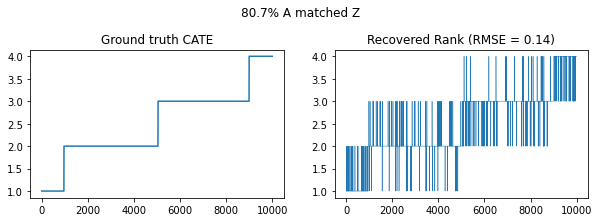

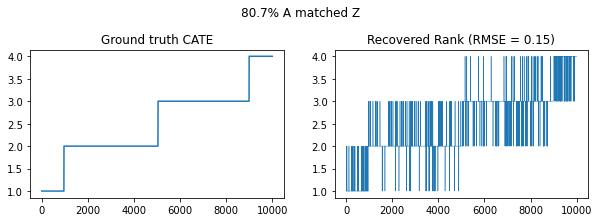

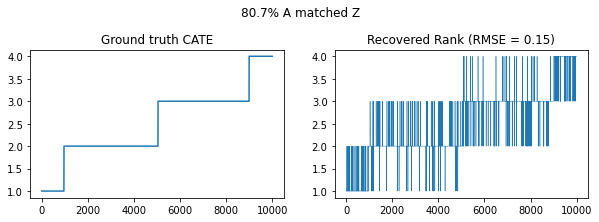

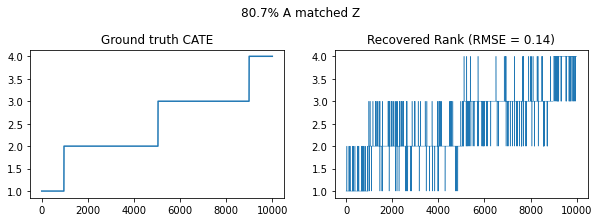

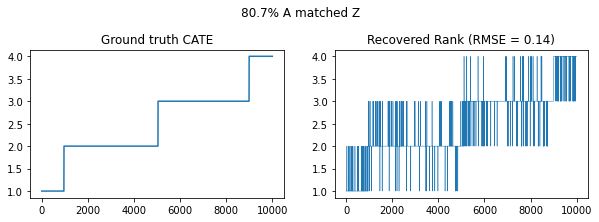

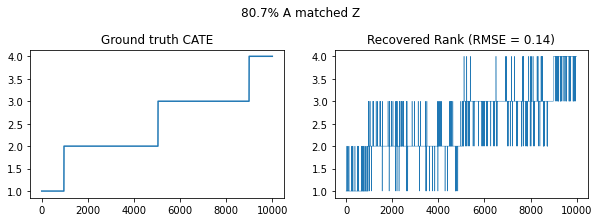

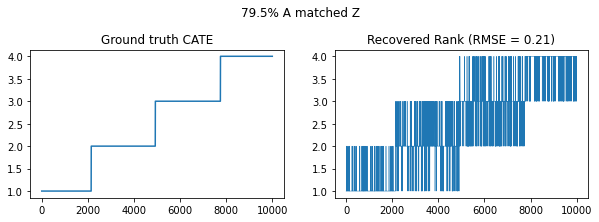

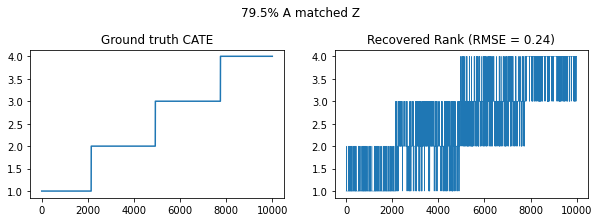

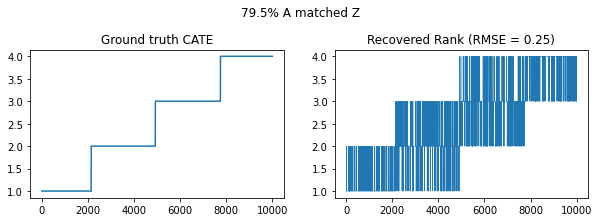

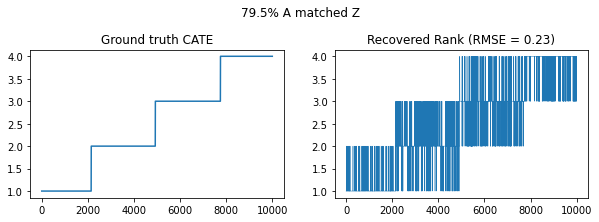

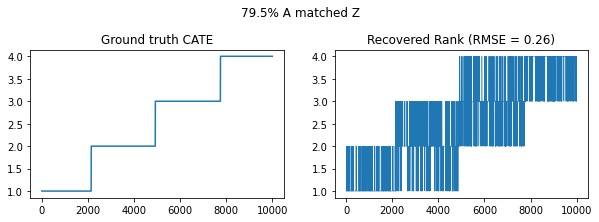

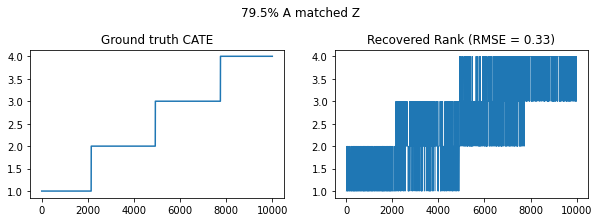

In [3]:
methods=['IPTW_LR', 'IPTW_SVM']
res=[]
res_refute=[]
for method in methods:

    alpha_range, sort_indice, a_matched_z, A_matched_Z_unobs, RMSEs_refute, RMSEs_unobs, RMSEs, corr_t, corr_y= refutation_analysis(method)

    A_matched_Z_unobs = np.array(A_matched_Z_unobs)
    RMSEs_unobs = np.array(RMSEs_unobs)

    sort_indice = np.argsort(A_matched_Z_unobs)
    sort_indice = sort_indice[::-1]
    
    res.append(RMSEs_unobs)
    res_refute.append(RMSEs_refute)

## RMSE Bar Plot

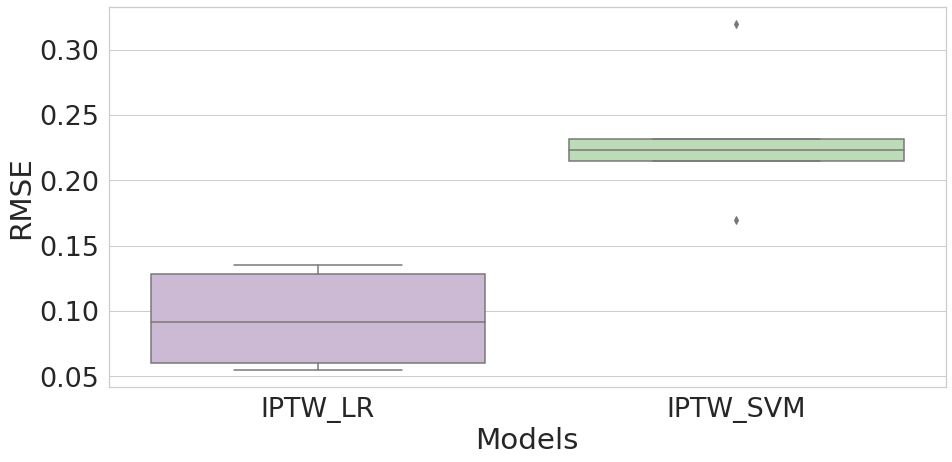

In [13]:
plot_df= pd.DataFrame(columns=methods)
for idx in range(len(methods)):
    plot_df[methods[idx]]= res_refute[idx]

sns.set(font_scale=2.45)
sns.set_style("whitegrid")
#sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

fig, ax1 = plt.subplots(figsize = [15,7])

fig = sns.boxplot(data = plot_df, palette='PRGn')
fig.set_xlabel('Models')
fig.set_ylabel('RMSE')
plt.savefig('images/sensitivity_analysis_synthetic.png', dpi=200)